# I-JEPA Masking Strategy Visualization and Statistics

This notebook visualizes and analyzes the masking strategy used during I-JEPA training. For a given input image, it repeatedly samples context and target patches using the exact same masking logic as in training, and accumulates statistics on which patches are selected as context or target. The results are visualized as overlays on the original image, with patch alpha proportional to selection frequency.

In [6]:
import torch
# restrict to 10 threads
torch.set_num_threads(10)
# print number of threads
print(f"Using {torch.get_num_threads()} threads for PyTorch")
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from pathlib import Path
import sys

# Add project root to path if needed
sys.path.append(r"C:\Users\dash\Documents\Wosler\learning_ai\ijepa")
from src.masks.multiblock import MaskCollator

# ---- Config ----
img1_path = r"C:\Users\dash\Documents\Wosler\learning_ai\ijepa\dataset\dataset_DATE_2025_06_12_TIME_14_29_13\val\class0\120.png"
img2_path = r"C:\Users\dash\Documents\Wosler\learning_ai\ijepa\dataset\dataset_DATE_2025_06_12_TIME_12_56_36\val\class0\378.png"
img3_path = r"C:\Users\dash\Documents\Wosler\learning_ai\ijepa\dataset\dataset_DATE_2025_06_12_TIME_14_29_13\val\class0\1195.png"
cfg = {
    "input_size": (224, 224),
    "patch_size": 16,
    "enc_mask_scale": (0.85, 1),
    "pred_mask_scale": (0.15, 0.2),
    "aspect_ratio": (0.75, 1.5),
    "nenc": 1,
    "npred": 4,
    "min_keep": 10,
    "allow_overlap": False
}
num_trials = 1000
device = torch.device("cpu")

Using 10 threads for PyTorch


In [7]:
# ---- Load and preprocess image ----
transform = transforms.Compose([
    transforms.Resize(cfg["input_size"]),
    transforms.CenterCrop(cfg["input_size"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = Image.open(img1_path).convert("RGB")
# Crop 10 pixels from each side: (left, upper, right, lower)
width, height = img.size
trim_width = 0
img = img.crop((trim_width, trim_width, width - trim_width, height - trim_width))
input_tensor = transform(img).unsqueeze(0).to(device)

# ---- Prepare MaskCollator ----
mask_collator = MaskCollator(
    input_size=cfg["input_size"],
    patch_size=cfg["patch_size"],
    enc_mask_scale=cfg["enc_mask_scale"],
    pred_mask_scale=cfg["pred_mask_scale"],
    aspect_ratio=cfg["aspect_ratio"],
    nenc=cfg["nenc"],
    npred=cfg["npred"],
    min_keep=cfg["min_keep"],
    allow_overlap=cfg["allow_overlap"]
)

In [8]:
# ---- Accumulate statistics over multiple maskings ----
grid_h = cfg["input_size"][0] // cfg["patch_size"]
grid_w = cfg["input_size"][1] // cfg["patch_size"]
num_patches = grid_h * grid_w

context_counts = np.zeros(num_patches, dtype=np.int32)
target_counts = np.zeros(num_patches, dtype=np.int32)

for trial in range(num_trials):
    # MaskCollator expects a batch, so wrap input_tensor in a list
    _, context_masks, target_masks = mask_collator([input_tensor])
    context_indices = context_masks[0].squeeze(0).cpu().numpy().flatten()
    target_indices = target_masks[0].squeeze(0).cpu().numpy().flatten()
    for idx in context_indices:
        context_counts[idx] += 1
    for idx in target_indices:
        target_counts[idx] += 1

print("Accumulated context patch counts:", context_counts)
print("Accumulated target patch counts:", target_counts)

Accumulated context patch counts: [938 895 845 799 731 712 705 697 705 770 840 886 937   0 879 794 695 611
 528 488 485 492 513 600 697 794 884   0 817 686 556 453 373 330 331 338
 376 477 586 715 839   0 774 593 436 320 233 186 199 217 250 357 473 633
 787   0 725 515 338 215 137 104 111 128 166 266 373 553 731   0 678 449
 278 164 102  78  78  86 123 216 321 497 706   0 664 429 262 144  89  58
  65  70 103 189 292 469 694   0 694 456 289 172 102  77  78  81 115 211
 321 490 706   0 737 512 343 226 145 121 125 118 164 265 374 546 743   0
 785 583 427 318 221 195 199 202 258 359 470 624 795   0 839 669 535 434
 337 311 322 325 380 471 572 704 843   0 886 761 655 574 487 465 489 504
 546 623 706 809 892   0 945 882 825 778 724 704 702 711 733 782 834 893
 944   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Accumulated target patch counts: [ 15  24  39  64  87  95  91  95  85  64  40  30  16   0  36  61  96 135
 171 183 174 177 155 120  84  56  33   0  58  97 148 201 248 260

In [9]:
# ---- Combined visualization for context and target patch statistics ----
def overlay_patch_statistics_combined(img_tensor, context_counts, target_counts, patch_size, grid_h, grid_w, save_path=None):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    img_disp = img_tensor * std + mean
    img_disp = img_disp.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img_disp = np.clip(img_disp, 0, 1)

    max_context = context_counts.max()
    max_target = target_counts.max()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    for ax, patch_counts, color, title, max_count in zip(
        axs,
        [context_counts, target_counts],
        ["blue", "red"],
        ["Context Patch Selection Frequency", "Target Patch Selection Frequency"],
        [max_context, max_target],
    ):
        ax.imshow(img_disp)
        ax.set_title(title, fontsize=18)
        ax.axis("off")
        for idx, count in enumerate(patch_counts):
            if count == 0:
                continue
            row, col = divmod(idx, grid_w)
            y, x = row * patch_size, col * patch_size
            alpha = count / max_count if max_count > 0 else 0
            rect = plt.Rectangle(
                (x, y), patch_size, patch_size,
                linewidth=2,
                edgecolor=color,
                facecolor=color if color != "none" else "none",
                alpha=0.2 + 0.6 * alpha,
                fill=True
            )
            ax.add_patch(rect)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

# ---- Visualize 20 random selections of context and target patches ----
def visualize_multiple_selections(img_tensor, mask_collator, patch_size, grid_h, grid_w, n_selections=20, save_path=None):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    img_disp = img_tensor * std + mean
    img_disp = img_disp.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img_disp = np.clip(img_disp, 0, 1)

    fig, axs = plt.subplots(4, 5, figsize=(20, 16))
    axs = axs.flatten()
    for i in range(n_selections):
        _, context_masks, target_masks = mask_collator([img_tensor])
        context_indices = context_masks[0].squeeze(0).cpu().numpy().flatten()
        target_indices = target_masks[0].squeeze(0).cpu().numpy().flatten()
        ax = axs[i]
        ax.imshow(img_disp)
        ax.set_title(f"Selection {i+1}", fontsize=14)
        ax.axis("off")
        # Draw context patches (blue)
        for idx in context_indices:
            row, col = divmod(idx, grid_w)
            y, x = row * patch_size, col * patch_size
            rect = plt.Rectangle(
                (x, y), patch_size, patch_size,
                linewidth=2, edgecolor="blue", facecolor="blue", alpha=0.4, fill=True
            )
            ax.add_patch(rect)
        # Draw target patches (red)
        for idx in target_indices:
            row, col = divmod(idx, grid_w)
            y, x = row * patch_size, col * patch_size
            rect = plt.Rectangle(
                (x, y), patch_size, patch_size,
                linewidth=2, edgecolor="red", facecolor="red", alpha=0.4, fill=True
            )
            ax.add_patch(rect)
    plt.tight_layout()
    plt.show()


Image 1 - Accumulated context patch counts: [941 872 817 768 713 684 701 716 742 791 842 887 939   0 885 759 663 584
 493 462 478 487 529 614 694 774 882   0 850 669 521 422 325 279 289 308
 360 453 558 676 826   0 798 584 422 312 213 171 182 195 242 339 455 586
 764   0 742 513 338 222 137 101 114 114 152 241 359 514 710   0 703 473
 287 178 102  67  77  76 114 202 318 472 673   0 688 446 270 169  91  64
  58  65  96 184 296 451 661   0 699 484 328 195 112  78  75  77 106 208
 325 477 691   0 739 531 385 247 158 121 116 117 142 247 375 525 729   0
 784 614 475 335 234 188 190 214 244 357 478 617 786   0 836 689 569 447
 352 307 322 341 386 490 598 711 845   0 890 789 704 610 530 486 491 502
 543 628 707 795 899   0 950 891 848 797 751 712 719 714 740 792 836 890
 953   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Image 1 - Accumulated target patch counts: [ 18  27  39  59  76  81  82  86  81  62  48  34  19   0  30  52  77 112
 151 159 161 162 149 108  82  57  28   0  41

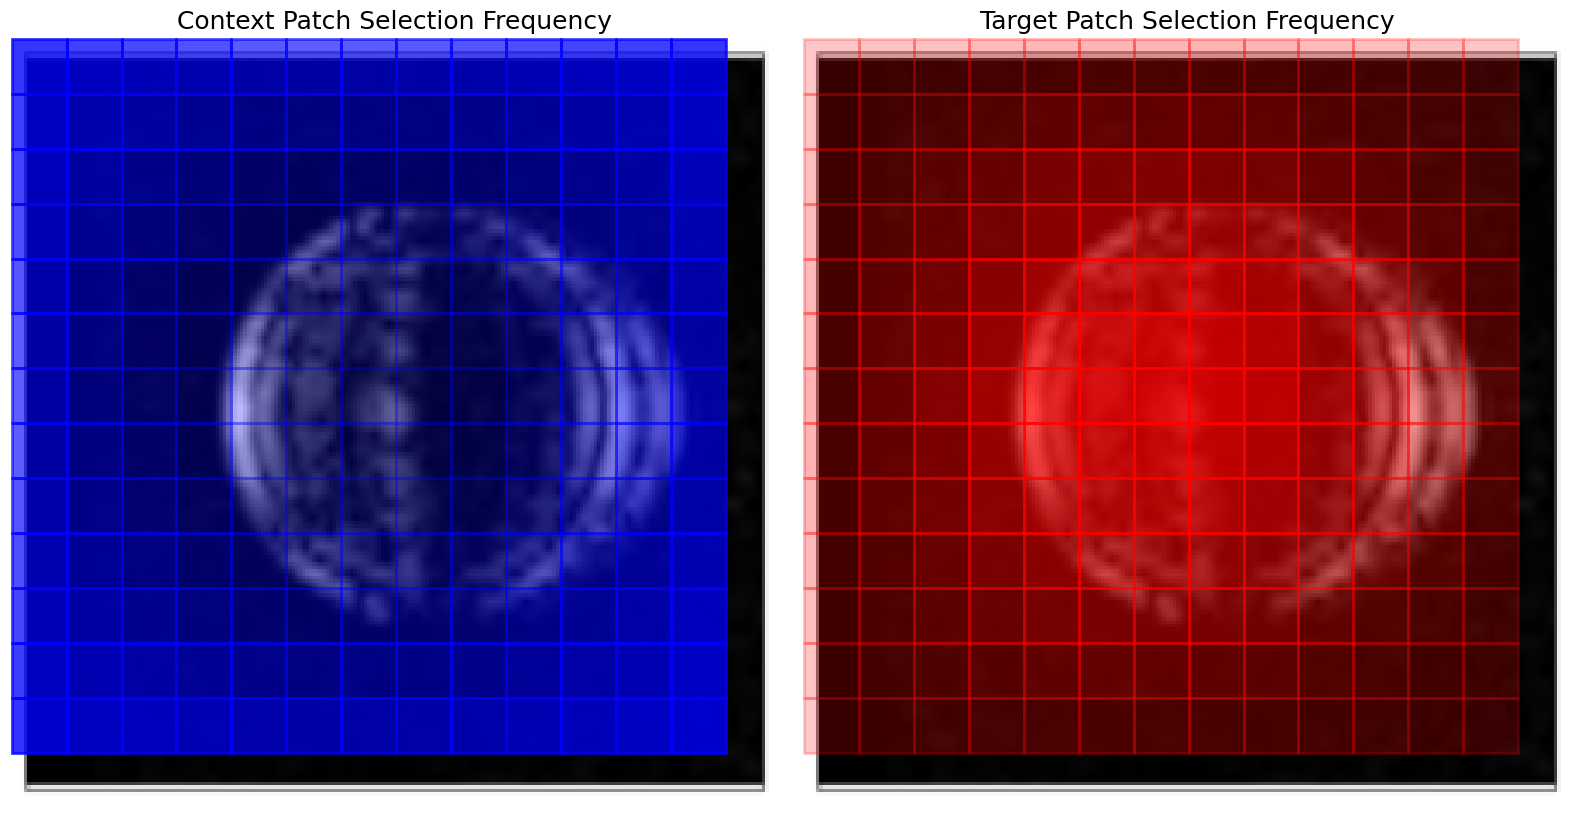

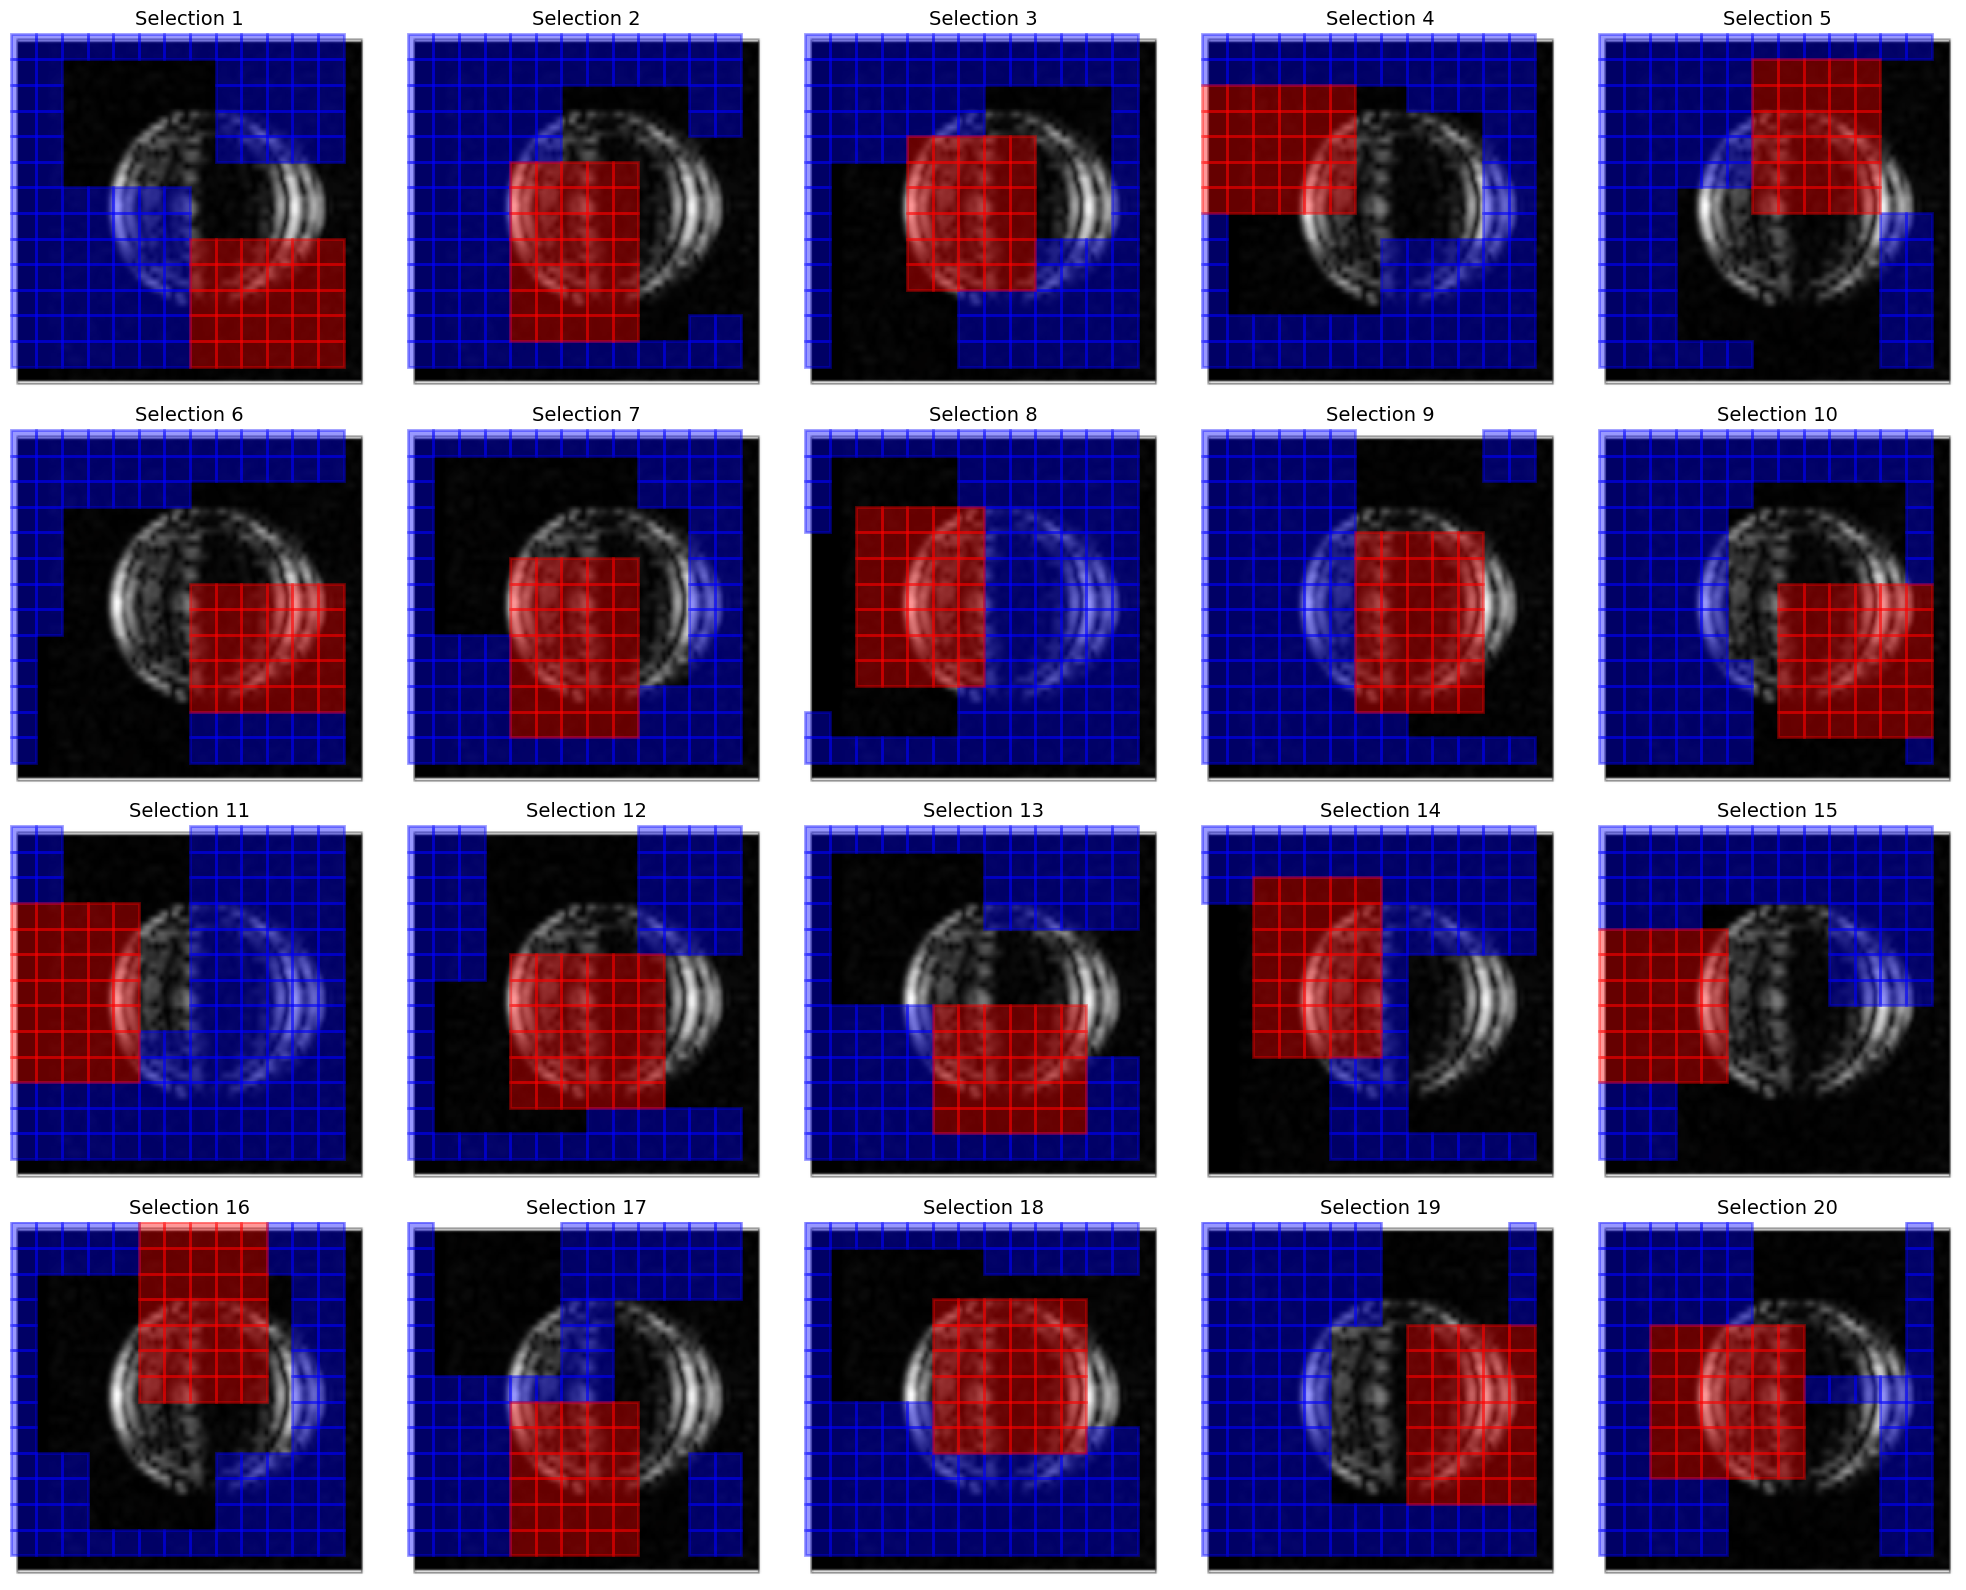

Image 2 - Accumulated context patch counts: [957 889 833 774 714 686 671 676 698 765 820 883 939   0 897 782 680 603
 517 471 466 477 501 586 680 793 894   0 849 694 565 467 371 321 317 318
 339 433 539 680 837   0 798 614 459 350 243 201 200 208 239 326 442 609
 795   0 754 540 371 254 157 123 116 114 141 223 345 520 746   0 723 500
 322 213 124  85  91  75 104 178 286 478 715   0 691 459 300 189 103  80
  67  55  87 155 253 459 710   0 711 475 313 184 104  78  75  64 106 186
 297 494 720   0 737 514 364 233 144 109 110 109 155 243 356 541 739   0
 789 597 447 318 224 170 173 180 245 340 458 629 796   0 837 676 547 438
 340 285 283 296 364 451 550 706 848   0 880 762 662 582 495 460 460 466
 516 585 674 791 888   0 937 872 810 759 711 696 692 687 724 770 819 884
 939   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Image 2 - Accumulated target patch counts: [ 14  30  44  55  73  79  79  77  84  62  50  34  19   0  26  62  90 118
 155 176 177 168 162 127  94  54  29   0  40

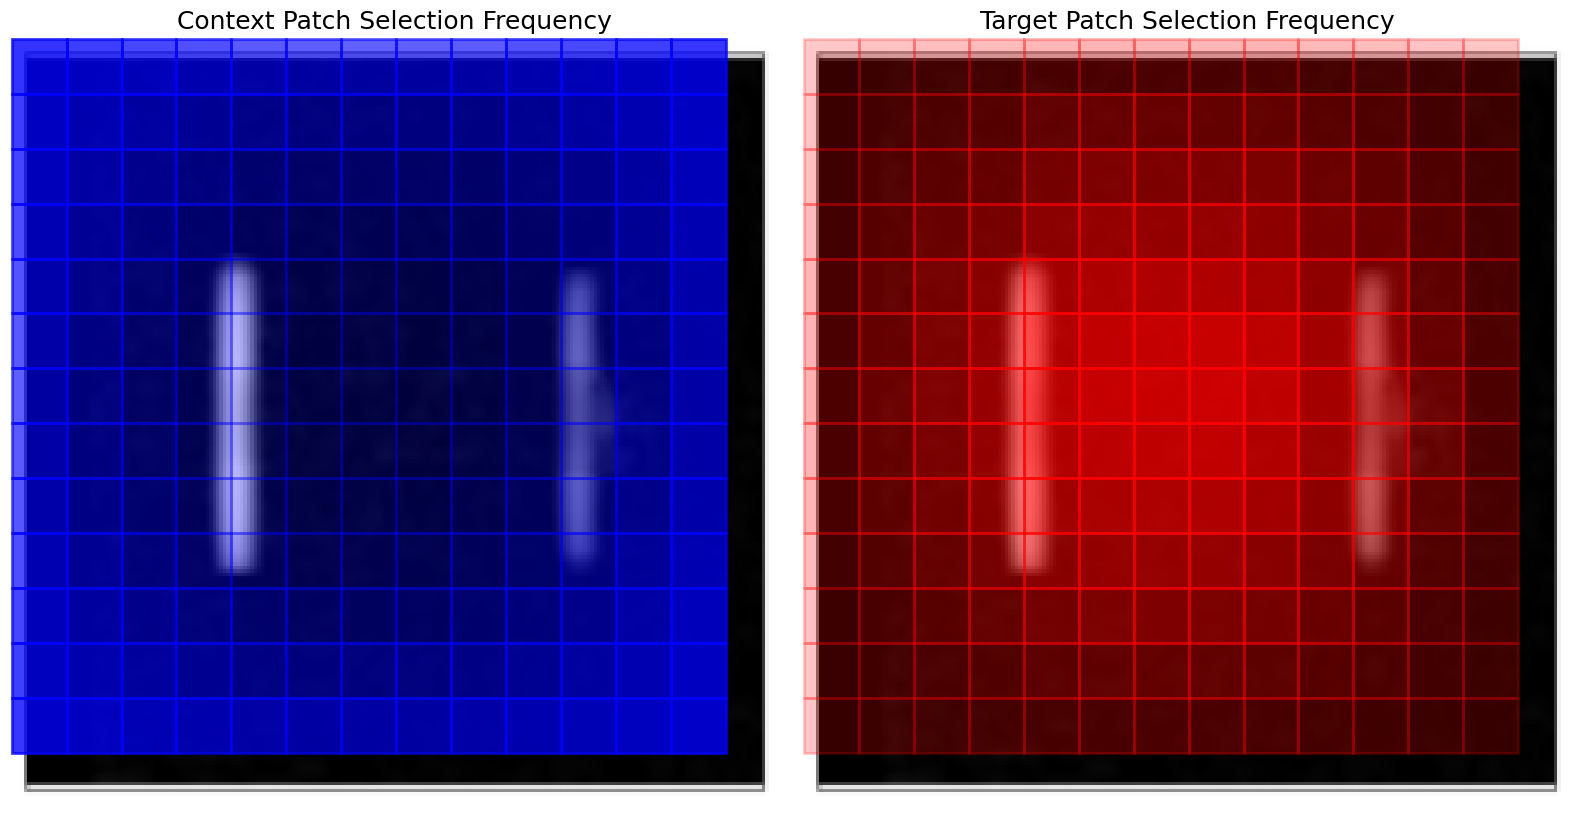

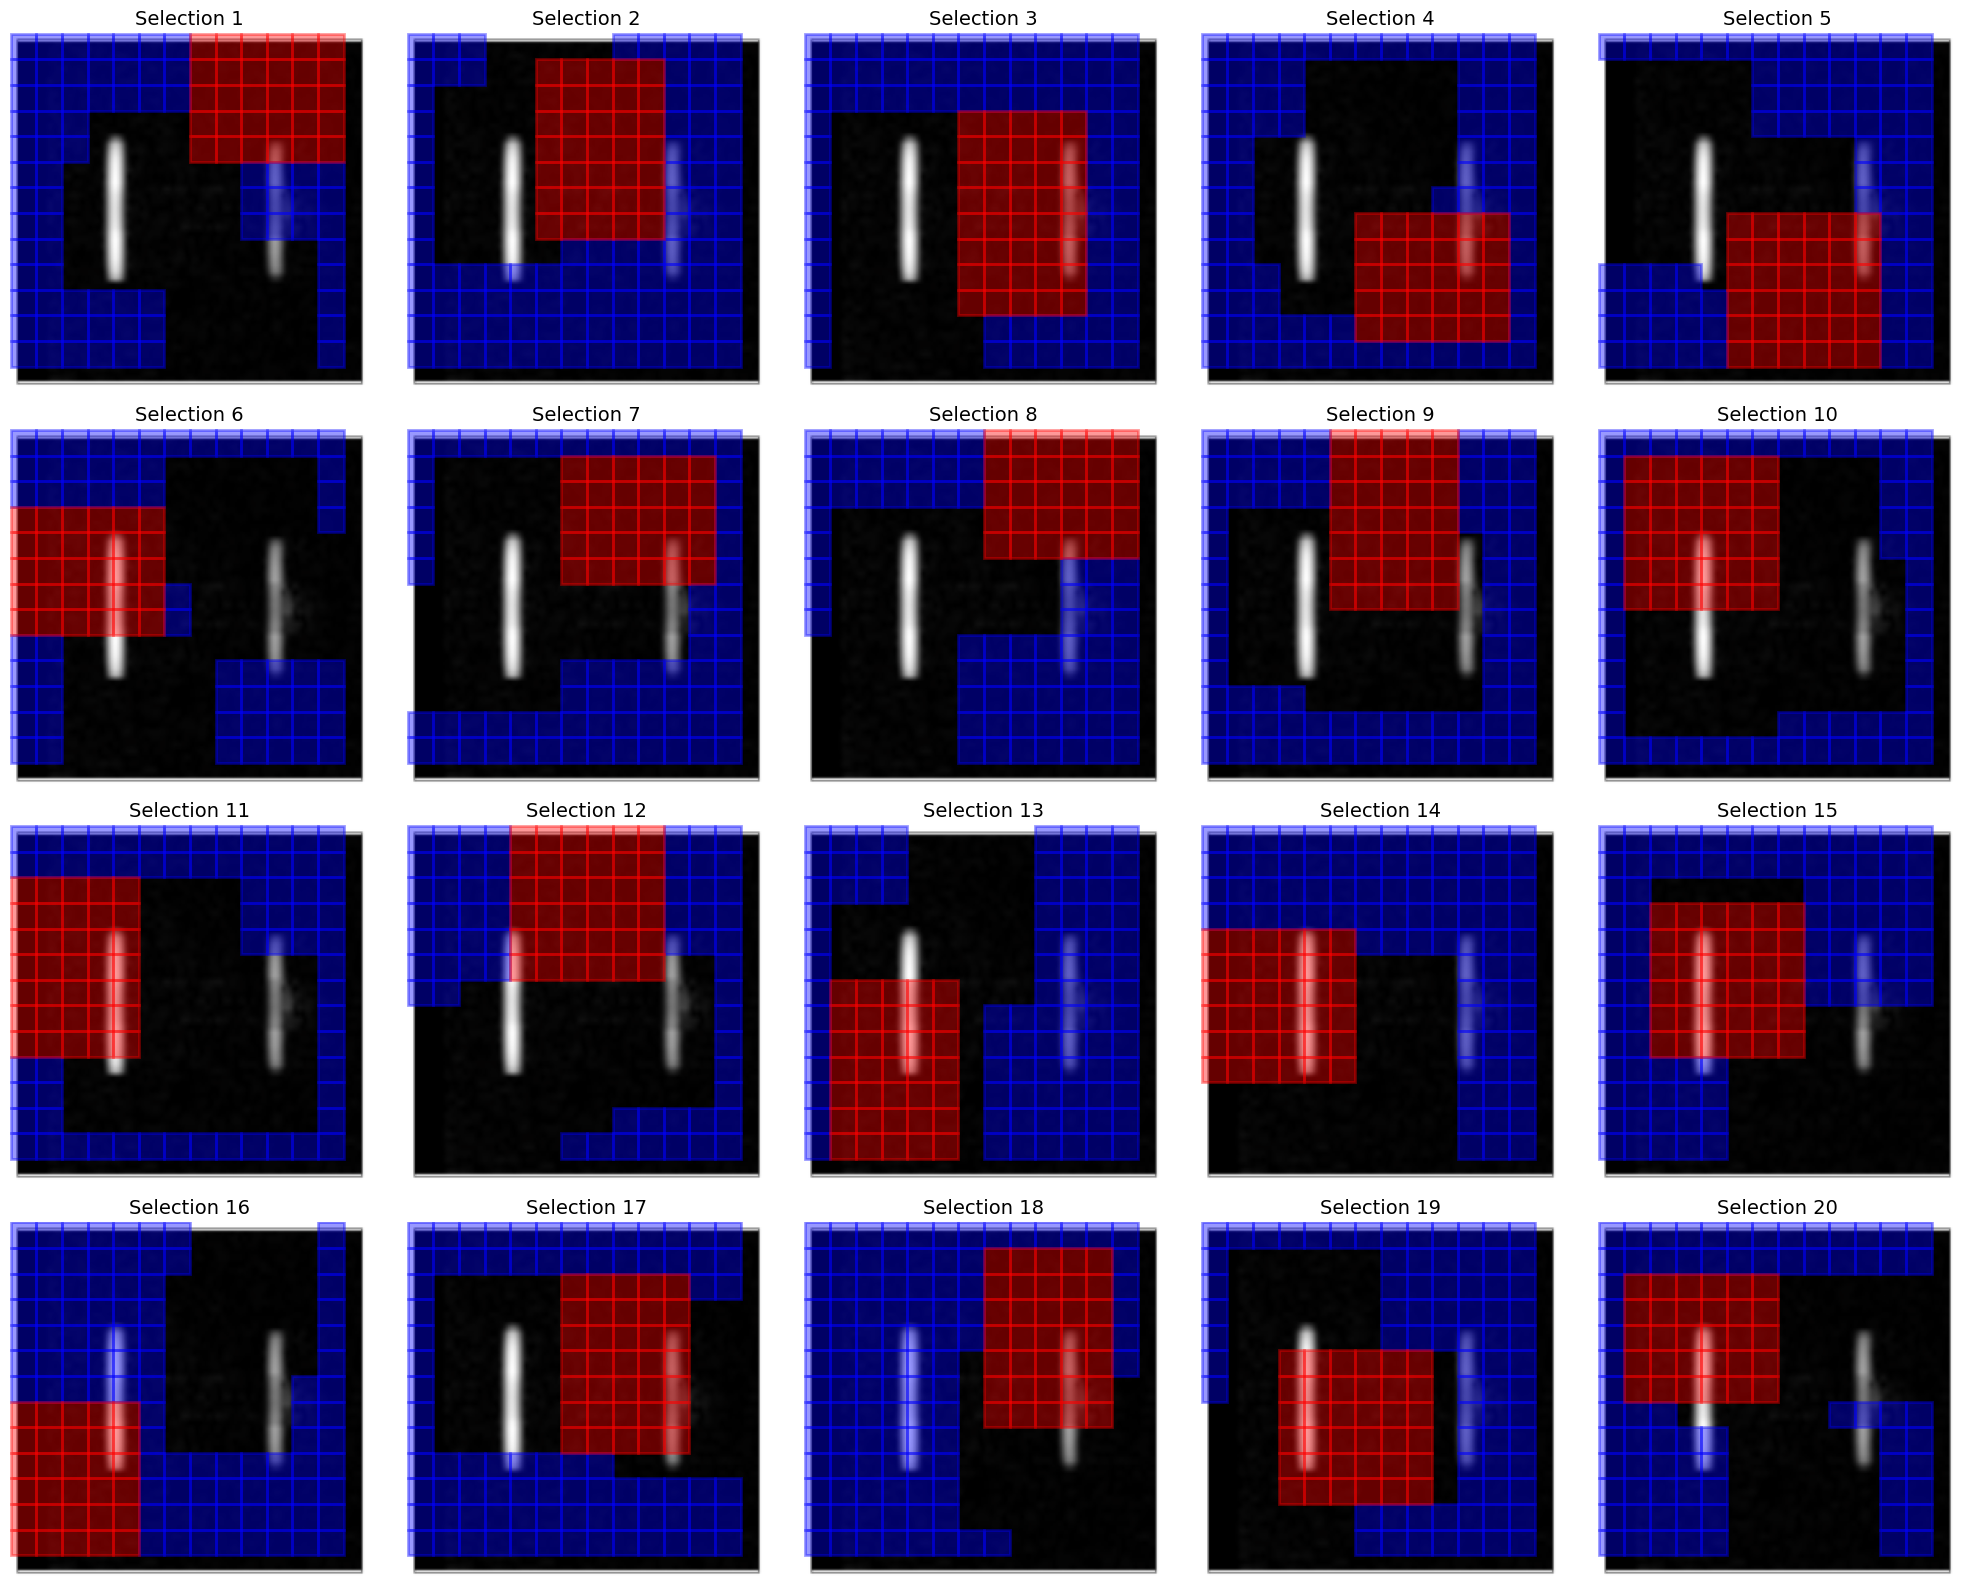

Image 3 - Accumulated context patch counts: [948 884 836 791 739 712 720 718 739 783 834 886 945   0 882 769 670 598
 523 487 499 497 525 593 679 774 883   0 826 668 541 450 358 325 327 338
 368 452 555 684 829   0 776 585 434 332 235 202 196 216 245 338 449 602
 772   0 727 510 343 242 155 123 110 131 158 241 354 524 728   0 702 459
 305 205 120  84  71  77 101 186 283 467 694   0 692 430 270 169  91  68
  64  53  79 163 265 433 669   0 706 466 294 196 114  85  79  76  93 176
 292 465 685   0 741 528 355 257 161 132 112 122 145 239 360 528 738   0
 783 604 445 340 240 200 182 187 225 327 445 600 783   0 832 678 553 460
 368 319 312 313 355 457 565 693 840   0 883 767 670 595 523 479 492 495
 531 614 703 797 895   0 942 886 822 778 732 709 725 728 755 802 848 903
 949   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Image 3 - Accumulated target patch counts: [ 16  35  47  63  72  83  78  82  72  62  47  31  19   0  39  76 107 134
 154 168 162 165 148 127 100  66  36   0  49

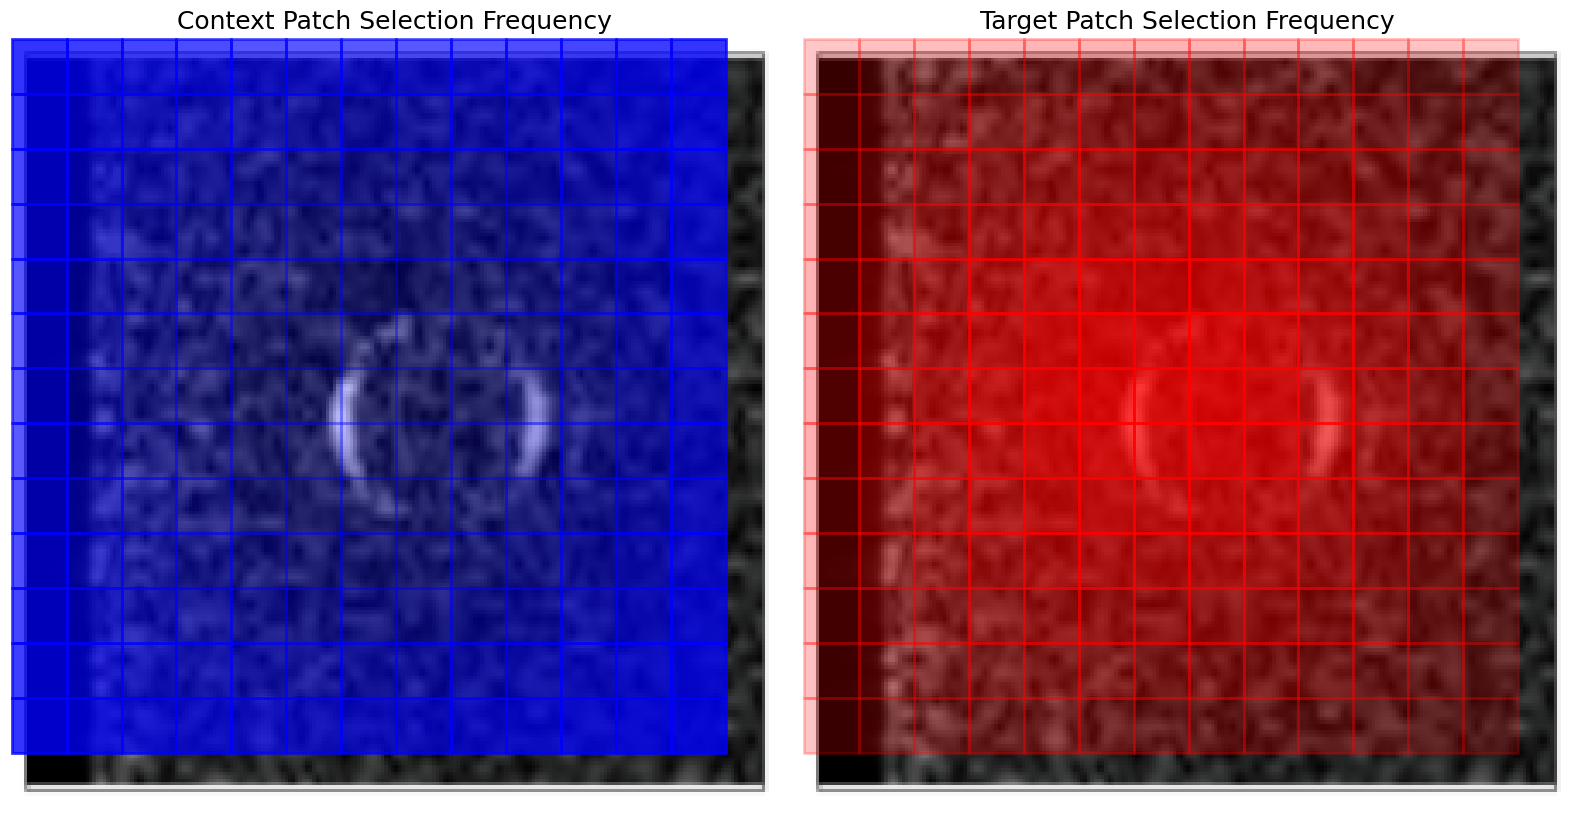

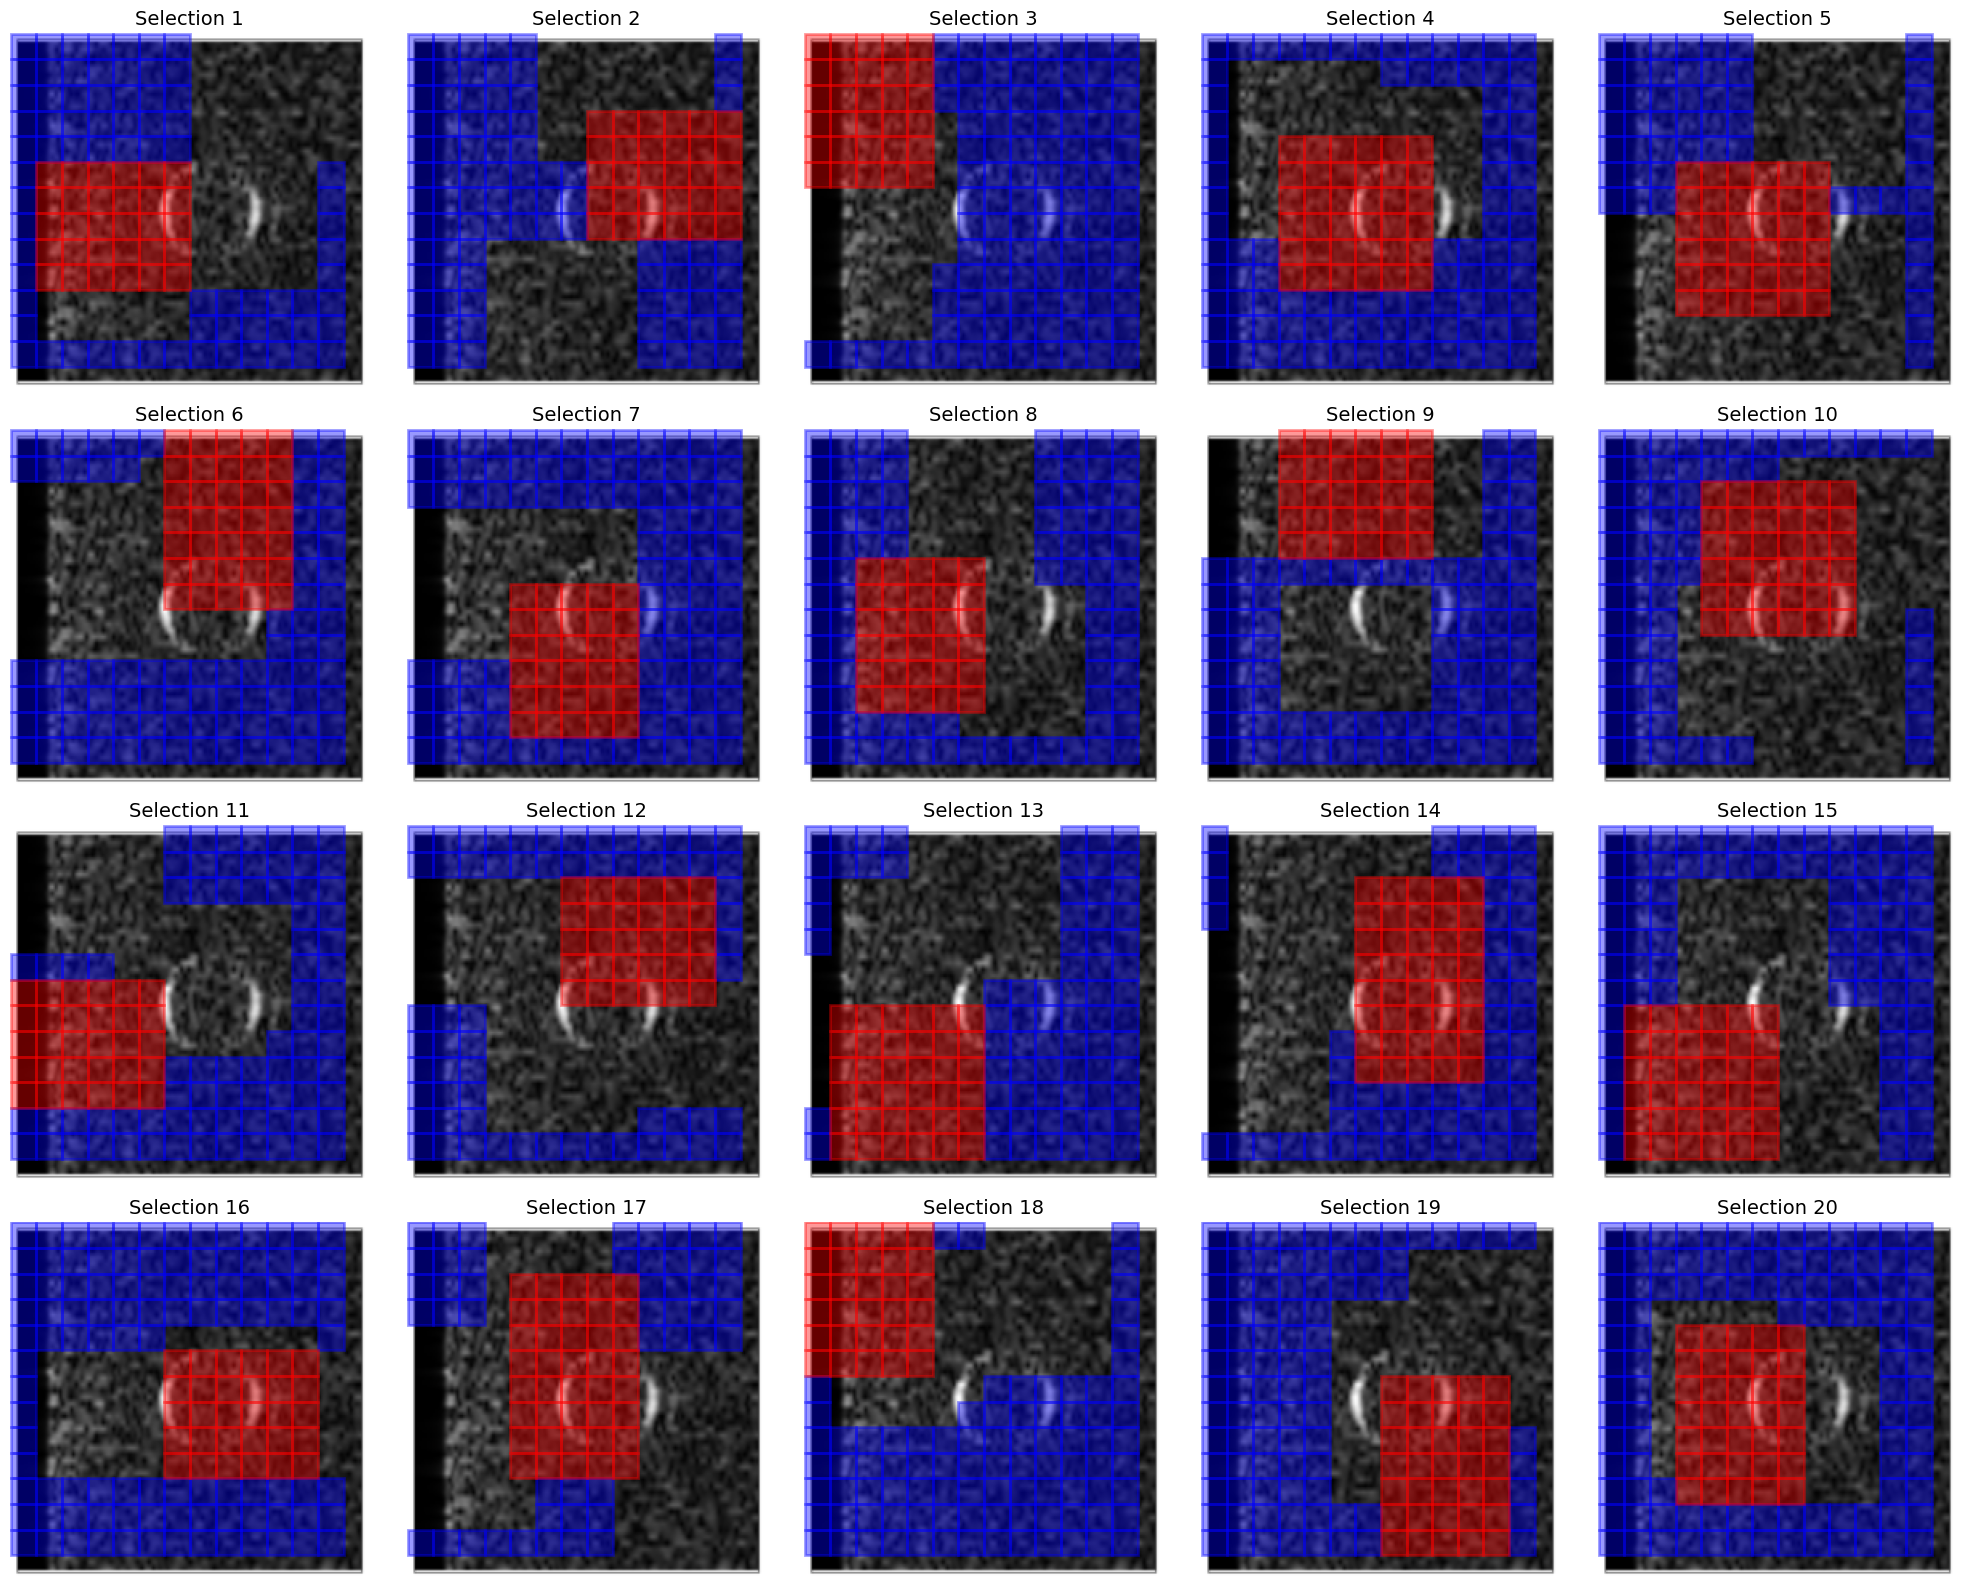

In [10]:

# ---- Evaluate statistics and selections for two images ----
for img_idx, img_path_cur in enumerate([img1_path, img2_path, img3_path], 1):
    img = Image.open(img_path_cur).convert("RGB")
    width, height = img.size
    trim_width = 0  # Or 10 if you want to trim margins
    img = img.crop((trim_width, trim_width, width - trim_width, height - trim_width))
    input_tensor = transform(img).unsqueeze(0).to(device)

    # ---- Prepare MaskCollator (reuse existing mask_collator) ----
    # ---- Accumulate statistics over multiple maskings ----
    context_counts = np.zeros(num_patches, dtype=np.int32)
    target_counts = np.zeros(num_patches, dtype=np.int32)
    for trial in range(num_trials):
        _, context_masks, target_masks = mask_collator([input_tensor])
        context_indices = context_masks[0].squeeze(0).cpu().numpy().flatten()
        target_indices = target_masks[0].squeeze(0).cpu().numpy().flatten()
        for idx in context_indices:
            context_counts[idx] += 1
        for idx in target_indices:
            target_counts[idx] += 1
    print(f"Image {img_idx} - Accumulated context patch counts:", context_counts)
    print(f"Image {img_idx} - Accumulated target patch counts:", target_counts)

    # ---- Combined statistics visualization ----
    overlay_patch_statistics_combined(
        input_tensor,
        context_counts,
        target_counts,
        patch_size=cfg["patch_size"],
        grid_h=grid_h,
        grid_w=grid_w,
        save_path=f"mask_statistics_combined_img{img_idx}.png"
    )

    # ---- Visualize 20 random selections ----
    visualize_multiple_selections(
        input_tensor,
        mask_collator,
        patch_size=cfg["patch_size"],
        grid_h=grid_h,
        grid_w=grid_w,
        n_selections=20,
        save_path=f"mask_selections_4x5_img{img_idx}.png"
    )
